# 第2部 Box-Jenkins法とその周辺

## パッケージインポート

In [1]:
# !pip install statsmodels
# # !pip install rdatasets
# !pip install pmdarima

In [2]:
import datetime
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import statsmodels.graphics.api as smg
import statsmodels.tsa.api as tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

# from pydataset import data
from rdatasets import data

%matplotlib inline
# sns.set(font="DejaVu Sans") #seabornを日本語対応

In [3]:
df = data("Seatbelts")
df.shape

(192, 8)

## 第2部-7章 RによるARIMAモデル

### データ準備

In [4]:
df = data("Seatbelts")

year = [[i]*12 for i in range(1969, 1985)]
year = list(itertools.chain.from_iterable(year))

month = [list(range(1,13)) for i in range(1969, 1985)]
month = list(itertools.chain.from_iterable(month))

df['year'] = year
df['month'] = month

yyyymm = [str(i)+'-'+str(j) for i,j in zip(df['year'], df['month'])]
df['date'] = pd.to_datetime(yyyymm)
df.set_index('date', inplace=True)

In [5]:
df_front = df['front']

### 対数差分系列

In [6]:
df_front

date
1969-01-01    867
1969-02-01    825
1969-03-01    806
1969-04-01    814
1969-05-01    991
             ... 
1984-08-01    644
1984-09-01    643
1984-10-01    641
1984-11-01    711
1984-12-01    721
Name: front, Length: 192, dtype: int64

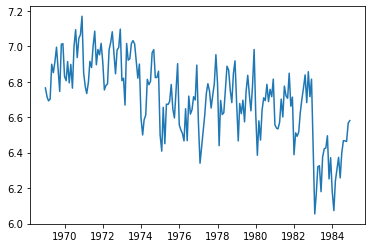

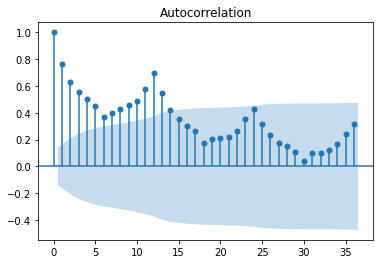

In [7]:
# 対数差分系列の可視化

# 時系列描画
plt.plot(np.log(df_front));

# コレログラム（自己相関）描画
plot_acf(df_front, lags=36);

### 季節差分系列

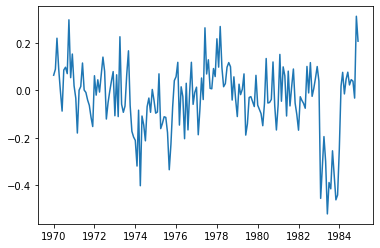

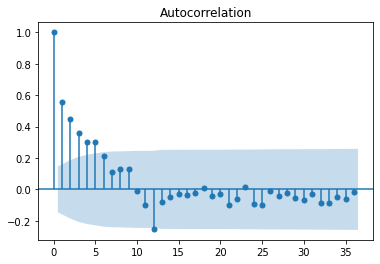

In [8]:
df_front_log_diff = np.log(df_front).diff(12)

# 時系列描画
plt.plot(df_front_log_diff);

# コレログラム（自己相関）描画
plot_acf(df_front_log_diff.dropna(), lags=36);

In [9]:
#自己相関系列の値
tsa.stattools.acf(df_front, nlags=None)

c:\users\sk0ea\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
c:\users\sk0ea\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


array([1.        , 0.76171011, 0.62785233, 0.55075853, 0.50248192,
       0.45287947, 0.36787167, 0.40072598, 0.42693172, 0.45562834,
       0.48720213, 0.57950984, 0.69242629, 0.54439641, 0.42138786,
       0.35009229, 0.30263493, 0.26046324, 0.17580323, 0.2007498 ,
       0.20780282, 0.21989189, 0.26320471, 0.35531106, 0.43095806,
       0.31779323, 0.23179849, 0.17100168, 0.15004702, 0.11014894,
       0.04052578, 0.09824221, 0.10168315, 0.1184929 , 0.16687116,
       0.23757421, 0.31549385, 0.21371976, 0.09361652, 0.05669948,
       0.03525713])

### 訓練データ・テストデータの分割

In [10]:
seatbelts_log = df[['front', 'PetrolPrice', 'law']]
seatbelts_log.loc[:, 'front'] = np.log(seatbelts_log['front'])
seatbelts_log.loc[:, 'PetrolPrice'] = np.log(seatbelts_log['PetrolPrice'])



c:\users\sk0ea\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [11]:
train = seatbelts_log.loc[:'1983-12']
test = seatbelts_log.loc['1984-1':]
petro_law = train.iloc[:, 1:]
petro_law

,PetrolPrice,law
date,,
1969-01-01,-2.27330,0
1969-02-01,-2.27923,0
1969-03-01,-2.28217,0
1969-04-01,-2.29389,0
1969-05-01,-2.29244,0
...,...,...
1983-08-01,-2.12496,1
1983-09-01,-2.12963,1
1983-10-01,-2.13316,1


### ARIMAモデルの推定

In [12]:
arima = tsa.SARIMAX(train['front'], 
                    train[['PetrolPrice', 'law']], 
                    order=[1, 1, 1], 
                    seasonal_order=(1, 0, 0, 12)).fit()

arima.summary()

# arima = pm.ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))
# arima.fit(train['front'], train[['PetrolPrice', 'law']])
# arima.summary()

c:\users\sk0ea\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\sk0ea\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               front   No. Observations:                  180
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                 165.332
Date:                             Wed, 08 Sep 2021   AIC                           -318.664
Time:                                     21:48:12   BIC                           -299.539
Sample:                                 01-01-1969   HQIC                          -310.909
                                      - 12-01-1983                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
PetrolPrice    -0.3463      0.088     -3.928      0.000      -0.519      -0.174
law            -0.3719      0.045     -8.325      0.000      -0.459      -0.284
ar.L1           0.2590      0.090      2.872      0.004       0.082       0.436
ma.L1          -0.9503      0.024    -40.181      0.000      -0.997      -0.904
ar.S.L12        0.6877      0.059     11.666      0.000       0.572       0.803
sigma2          0.0088      0.001      8.423      0.000       0.007       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.80   Prob(JB):                         0.62
Heteroskedasticity (H):               0.81   Skew:                            -0.08
Prob(H) (two-sided):                  0.41   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
train

,front,PetrolPrice,law
date,,,
1969-01-01,6.765039,-2.27330,0
1969-02-01,6.715383,-2.27923,0
1969-03-01,6.692084,-2.28217,0
1969-04-01,6.701960,-2.29389,0
1969-05-01,6.898715,-2.29244,0
...,...,...,...
1983-08-01,6.421622,-2.12496,1
1983-09-01,6.426488,-2.12963,1
1983-10-01,6.495266,-2.13316,1


In [14]:
auto_arima = pm.auto_arima(
                    y=train['front'], 
                    X=train[['PetrolPrice', 'law']], 
#                   stepwise=False, 
                    seasonal=True,
                    max_order = 5,
                    m = 12,
                    approximation = False,
                    information_criterion='aic')
auto_arima

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(2, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [15]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  180
Model:             SARIMAX(0, 1, 2)x(2, 0, [1], 12)   Log Likelihood                 177.349
Date:                              Wed, 08 Sep 2021   AIC                           -338.699
Time:                                      21:49:43   BIC                           -313.200
Sample:                                  01-01-1969   HQIC                          -328.359
                                       - 12-01-1983                                         
Covariance Type:                                opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
PetrolPrice    -0.3568      0.100     -3.575      0.000      -0.552      -0.161
law            -0.3457      0.050     -6.919      0.000      -0.444      -0.248
ma.L1          -0.7132      0.077     -9.296      0.000      -0.864      -0.563
ma.L2          -0.1519      0.072     -2.104      0.035      -0.293      -0.010
ar.S.L12        1.1658      0.142      8.236      0.000       0.888       1.443
ar.S.L24       -0.1752      0.125     -1.397      0.162      -0.421       0.071
ma.S.L12       -0.8638      0.172     -5.026      0.000      -1.201      -0.527
sigma2          0.0073      0.001      7.359      0.000       0.005       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.97   Prob(JB):                         0.57
Heteroskedasticity (H):               0.80   Skew:                             0.03
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 残差のチェック

 - https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html
 - https://www.statsmodels.org/stable/generated/statsmodels.stats.stattools.jarque_bera.html

In [16]:
# 定常性の確認

# 反転可能性の確認

# 残差の自己相関の検定
print("Ljunng-Box test")
print("-"*20)
ljungbox = sm.stats.acorr_ljungbox(auto_arima.resid(), lags=range(0,25), return_df=True)
print(ljungbox)
print()
# 残差の正規性の検定
print("Jarque_Bera test")
print("-"*20)
ljungbox = sm.stats.jarque_bera(auto_arima.resid())
print(ljungbox)

Ljunng-Box test
--------------------
     lb_stat  lb_pvalue
0   1.368779        NaN
1   0.010761   0.917380
2   0.014720   0.992667
3   0.018305   0.999345
4   0.160209   0.996958
5   0.176153   0.999349
6   0.270617   0.999627
7   0.392663   0.999752
8   0.393443   0.999947
9   0.420462   0.999986
10  0.618672   0.999982
11  0.724198   0.999990
12  0.724779   0.999998
13  0.726165   0.999999
14  0.822079   1.000000
15  0.829328   1.000000
16  0.836231   1.000000
17  0.914639   1.000000
18  0.968505   1.000000
19  0.995411   1.000000
20  0.995818   1.000000
21  1.168819   1.000000
22  1.171031   1.000000
23  1.299206   1.000000
24  1.368779   1.000000

Jarque_Bera test
--------------------
(199430.3001899389, 0.0, 12.51089264621681, 164.1353994402571)


### 予測

In [29]:
y_train_pred = auto_arima.predict_in_sample(X=train[['PetrolPrice', 'law']])
y_test_pred = auto_arima.predict(len(test), test[['PetrolPrice', 'law']])

# testセットのRSME
print('train')
print(sm.tools.eval_measures.rmse(train['front'], y_train_pred, axis=0))
print('test')
print(sm.tools.eval_measures.rmse(test['front'], y_test_pred, axis=0))

train
0.45283034647969866
test
0.10273963288972653


In [30]:
test

,front,PetrolPrice,law
date,,,
1984-01-01,6.180017,-2.13897,1
1984-02-01,6.073045,-2.16459,1
1984-03-01,6.240276,-2.15645,1
1984-04-01,6.306275,-2.15973,1
1984-05-01,6.373320,-2.16443,1
1984-06-01,6.257668,-2.16476,1
1984-07-01,6.398595,-2.16338,1
1984-08-01,6.467699,-2.16459,1
1984-09-01,6.466145,-2.17074,1


In [41]:
y_test_pred_df = pd.DataFrame({'front': y_test_pred}, index=test.index)
y_test_pred_df

,front
date,
1984-01-01,6.142194
1984-02-01,6.093001
1984-03-01,6.172710
1984-04-01,6.224076
1984-05-01,6.299007
1984-06-01,6.256105
1984-07-01,6.379538
1984-08-01,6.411754
1984-09-01,6.357859


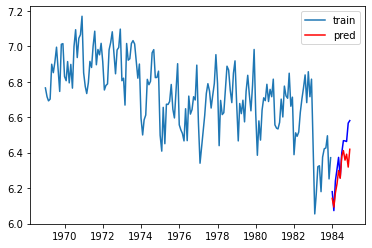

In [45]:
plt.plot(train['front'], label="train")
plt.plot(test['front'], "b")
plt.plot(y_test_pred_df['front'], "r", label="pred")
plt.legend()